### Homework

In homework you will have three parts:
1. Implement sampling for each of the models from the seminar. The code for this part is the same as for the seminar, albeit the VectorQuantizer class for VQ-VAE has a bit modified logic. Follow the sections of this notebook to implement the sampling method for each model. VQ-VAE sampling is tricky, so you might want to leave it till the end of your homework.  

2. Code a simple algorithm for manipulations in latent space - see the manual in the corresponding section.

3. As a bonus, code convolutional architectures for the models from the seminar.

The points for this homework are the following:

1. AE Sampling - 2
2. VAE Sampling - 2
3. RNN latent code generator for VQ-VAE - 4
4. VQ-VAE Sampling - 2
5. Latent space manipulations - 2
6. Bonus - up to 4


# Data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import time
from IPython import display
from sklearn.metrics import mean_squared_error
from IPython.display import Image

%matplotlib inline

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [4]:
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [5]:
data.shape

(13143, 45, 45, 3)

In [6]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


Normalise all images pixels value to be in range  of [0,1]

In [7]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [8]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [9]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

# Autoencoder

### Code

Remember from the lectures, that the simple autoencoder is going to take the input (X), compress it to some hidden (or latent) representation (z) and then reconstruct the original input (X') from it.

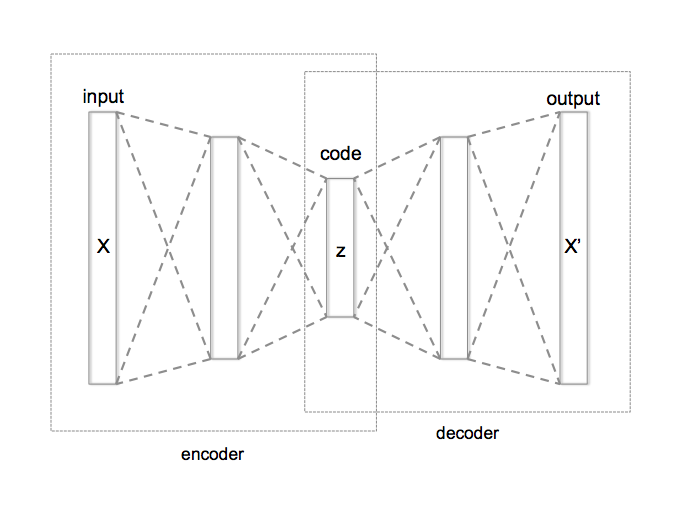

In [11]:
Image("Autoencoder_structure.png")

In [37]:
# Size of the autoencoder bottleneck
dimZ = 100

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()

        self.encode = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, dimZ),
            nn.BatchNorm1d(dimZ),
        )

        self.decode = torch.nn.Sequential(
            nn.Linear(dimZ, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # We can ask to code things here
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)

        return reconstruction, latent_code

    def sample(self, n_samples, device):
        """ This is the method you need to code in your Homework"""
        latent_random_samples = torch.randn(n_samples, dimZ).to(device)
        samples_decoded = self.decode(latent_random_samples)
        return samples_decoded

In [38]:
class ModelForwardWrapper(nn.Module):
    def __init__(self, model, mode):
        super().__init__()
        self.model = model
        self.mode = mode

    def encode(self, input):
        if self.mode == "ae":
            return self.model.encode(input)
        elif self.mode == "vae":
            return self.model.encode(input)[0]
        elif self.mode == "vq-vae":
            return self.model.encode(input)[..., 0, 0]
        else:
            raise NotImplementedError

In [39]:
device = torch.device("cuda:0")

In [40]:
# Create MSE loss function
criterion = torch.nn.MSELoss()
autoencoder = Autoencoder(input_size=X_train.shape[1], hidden_size=300).to(device)
# Use Adam optimizer
opt = optim.Adam(autoencoder.parameters())

In [41]:
num_epochs = 50

train_loss = []
val_loss = []

In [42]:
def compute_loss(X_batch, y_batch):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    probs, _ = autoencoder(X_batch)
    return F.mse_loss(probs, y_batch)

In [43]:
num_epochs = 5

Notice, that in the training loop the training losses defined for different models are not comparable between each other. However, for the validation loss we are going to use MSE error on the validation set. Thus, we can compare the quality of reconstruction between different models.

In [64]:
# Train your autoencoder

from typing import Literal
def train_model(model, model_type: Literal["ae", "vae", "vq-vae"]):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        loss_batch = []
        if model_type == "vq-vae":
            vq_loss_batch = []
        for X_batch, _ in train_loader:
            # train on batch
            if model_type == "vq-vae":
                recon_loss, vq_loss_ = compute_loss(X_batch, X_batch)
                loss = recon_loss + vq_loss_
                vq_loss_batch.append(vq_loss_.data.cpu().numpy())
            else:
                loss = compute_loss(X_batch, X_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            loss_batch.append(loss.data.cpu().numpy())
        train_loss.append(np.mean(loss_batch))
        if model_type == "vq-vae":
            vq_loss.append(np.mean(vq_loss_batch))

        model.train(False)

        loss_batch = []
        for X_batch, _ in val_loader:
            if model_type == "ae":
                probs, _ = model(X_batch.to(device))
                x_pred = probs.data.cpu().numpy()
            elif model_type == "vae":
                mu_decoder, _, _, _ = model(X_batch.to(device))
                x_pred = mu_decoder.data.cpu().numpy()
            elif model_type == "vq-vae":
                probs, _ = model(X_batch.to(device))
                x_pred = probs.data.cpu().numpy()
            else:
                raise NotImplementedError
            loss_batch.append(mean_squared_error(X_batch, x_pred))
        val_loss.append(np.mean(loss_batch))


        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        plt.title("Validation loss")
        plt.xlabel("#Epoch")
        plt.ylabel("loss")
        plt.plot(val_loss, 'b',label='val loss')
        plt.plot(pd.Series(val_loss).ewm(span=10).mean(),'r',label='ewm val loss')
        plt.legend(loc='best')
        plt.grid()
        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1]))
        if model_type == "vq-vae":
            print("  training VQ loss (in-iteration): \t{:.6f}".format(vq_loss[-1]))
        print("  validation loss:\t\t{:.6f}".format(val_loss[-1]))

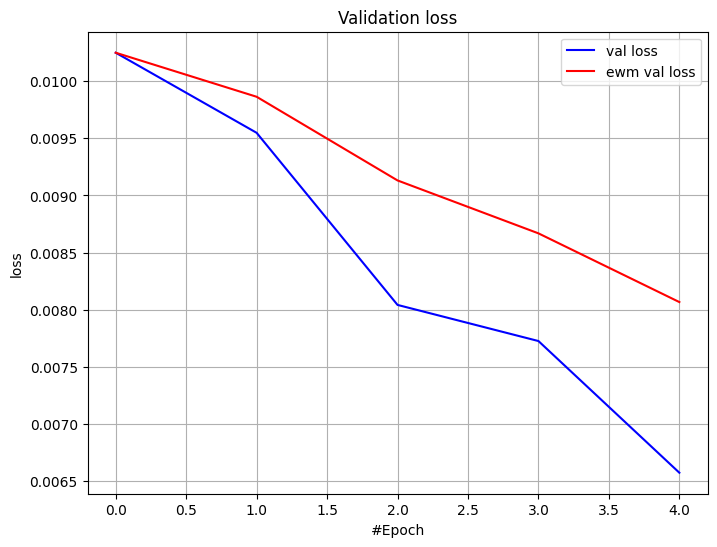

Epoch 5 of 5 took 4.010s
  training loss (in-iteration): 	0.006129
  validation loss:		0.006571


In [45]:
train_model(autoencoder, model_type="ae")

Now, lets examine how well the reconstruction is performed.

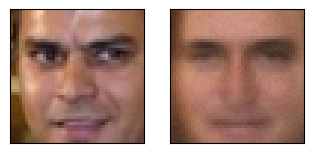

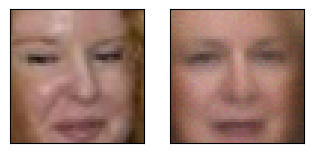

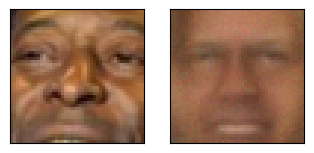

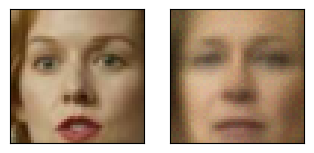

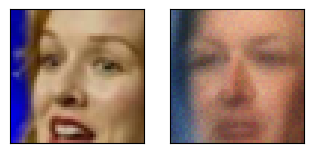

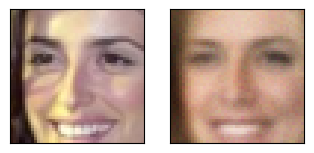

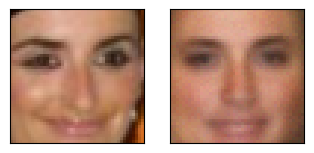

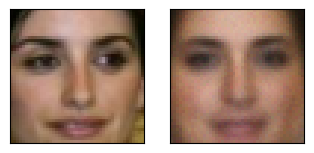

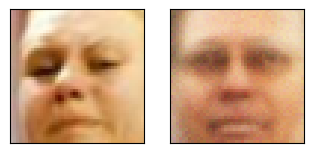

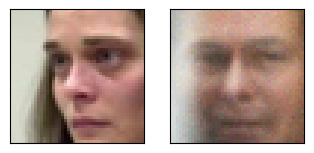

In [46]:
# Examine the reconstructions
autoencoder.train(False)
for j, img in enumerate(val_loader, 0):
    inp = img[0].to(device)
    pred, _ = autoencoder(inp)
    plot_gallery([img[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

### Sampling (HW) - 2 points

After you have implemented sampling method for AE, plot the samples from it here similar to the images above. What do you observe?

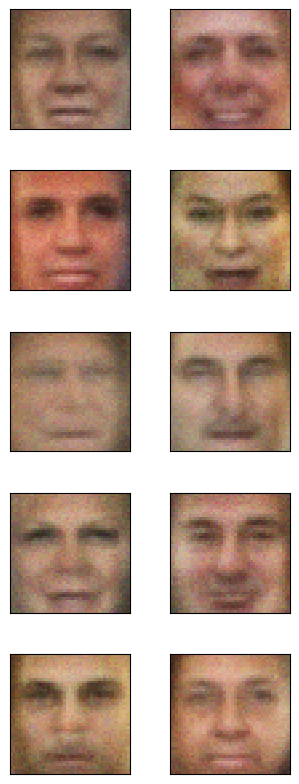

In [61]:
sampled_outputs = autoencoder.sample(10, device)
plot_gallery(sampled_outputs.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=2)

# VAE

### Code

In [87]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100


class VAE(nn.Module):
    def __init__(self, input_size=6075, hidden_size=400):
        super(VAE, self).__init__()

        self.fc_encode = nn.Linear(input_size, hidden_size)
        self.mu_encode = nn.Linear(hidden_size, dimZ)
        self.logstd_encode = nn.Linear(hidden_size, dimZ)


        self.fc_decode = nn.Linear(dimZ, hidden_size)
        self.mu_decode = nn.Linear(hidden_size, input_size)
        self.logstd_decode = nn.Linear(hidden_size, input_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.bn_encode = nn.BatchNorm1d(hidden_size)
        self.bn_decode = nn.BatchNorm1d(hidden_size)

        self.bn_mu_encode = nn.BatchNorm1d(dimZ)

    def encode(self, x):
        hidden = self.relu(self.bn_encode(self.fc_encode(x)))
        return self.bn_mu_encode(self.mu_encode(hidden)), self.logstd_encode(hidden)

    def decode(self, z):
        hidden = self.relu(self.bn_decode(self.fc_decode(z)))
        return self.sigmoid(self.mu_decode(hidden)),\
               self.logstd_decode(hidden)

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = torch.zeros_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_encoder, logstd_encoder = self.encode(x)
        z = self.gaussian_sampler(mu_encoder, logstd_encoder)
        mu_decoder, logstd_decoder = self.decode(z)

        return mu_decoder, logstd_decoder, mu_encoder, logstd_encoder

    def sample(self, n_samples, device):
        """ This is the method you need to code in your Homework"""
        mu_encoder_samples = torch.randn(n_samples, dimZ).to(device)
        logstd_encoder_samples = torch.randn(n_samples, dimZ).to(device)

        latent_random_samples = self.gaussian_sampler(mu_encoder_samples, logstd_encoder_samples)
        mu, _ = self.decode(latent_random_samples)
        return mu

In [88]:
def KL_divergence(mu, logsigma):
    return - 0.5 * (1 + 2 * logsigma  - mu.pow(2) - logsigma.exp().pow(2)).sum(dim=-1)

def log_likelihood(x, mu, logsigma):
    return - (logsigma  +\
              (mu - x).pow(2) / logsigma.exp().pow(2) * 0.5).sum(dim=-1)

def loss_vae(x, mu_decoder, logstd_decoder, mu_encoder, logstd_encoder):
    KL_value = KL_divergence(mu_encoder, logstd_encoder)
    log_value = log_likelihood(x, mu_decoder, logstd_decoder)
    return - (- 0.5 * KL_value + log_value).mean()

In [89]:
vae_autoencoder = VAE(input_size=X_train.shape[1], hidden_size=400).to(device)

opt = optim.Adam(vae_autoencoder.parameters())

num_epochs = 50

train_loss = []
val_loss = []

def compute_loss(X_batch, y_batch):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    return loss_vae(X_batch, *vae_autoencoder(X_batch))

In [90]:
# Recreate the dataset with smaller batch_size. VAEs are quite picky when it comes to model parameters and architectures

train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],))
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

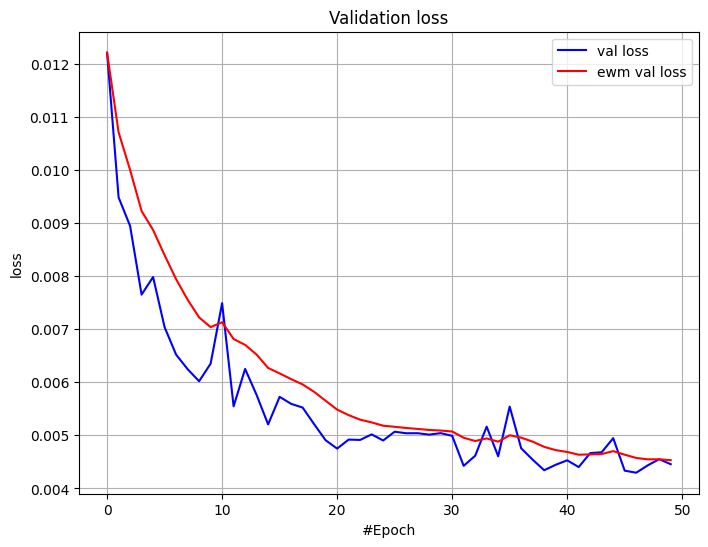

Epoch 50 of 50 took 4.600s
  training loss (in-iteration): 	-14606.186523
  validation loss:		0.004457


In [91]:
train_model(vae_autoencoder, model_type='vae')

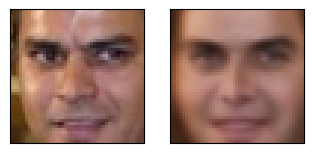

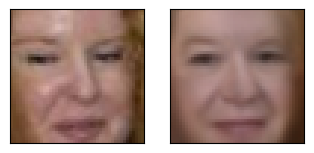

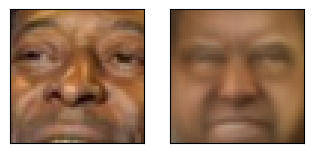

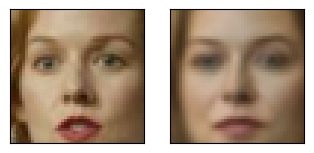

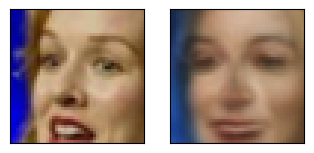

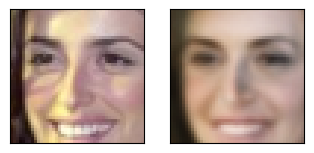

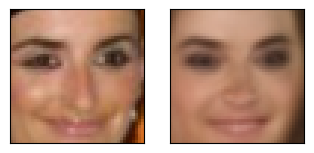

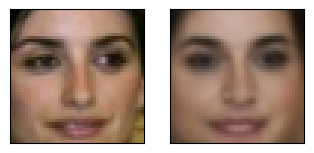

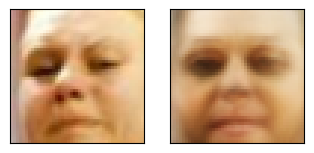

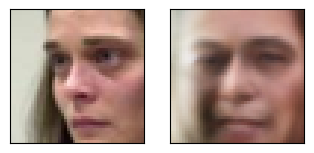

In [92]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)
vae_autoencoder.eval()
for j, img in enumerate(val_loader, 0):
    input = img[0].to(device)
    reconstruction_mu, _, _, _ = vae_autoencoder(input)
    plot_gallery([img[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

### Sampling (HW) - 2 points

Implement sampling for VAE similarly to AE.
Hint: in the sampling method,
- Sample z ~ N(0,1)
- Sample from N(decoder_mu(z), decoder_sigma(z))

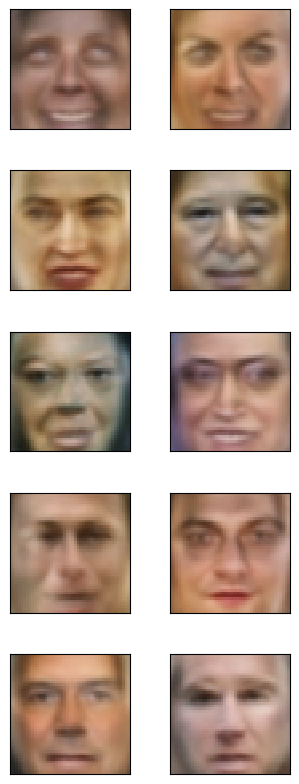

In [93]:
sampled_outputs = vae_autoencoder.sample(10, device)
plot_gallery(sampled_outputs.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=2)

What do you observe? Is there any difference w.r.t to an AE?

# VQ-VAE

### Code

In the previous example, we took a continuous normal distribution as a latent prior and posterior distribution.  The authors of the Vector Quantised (VQ) - VAE [link](https://arxiv.org/pdf/1711.00937.pdf) took a step further and imposed discrete (categorical) distributions over prior and posterior. This becomes especially handy when one wants to work with discrete sequences, such as language. This technique is actively used nowadays, for example, in DALL-E.


The loss for the VQ-VAE is:


$$
L = log p(x|z_q(x)) + ||\ sg[z_e(x)] - e \ ||^2 + ||\ z_e(x) - sg[e]\ || ^2,
$$

where the first term is the log-likelihood of the data, given quantised embedding, the second term provides learning for the trainable embeddings $e$ and the last term is a regularisation for the encoder embeddings.

In [ ]:
Image("va_vae.png")

In [ ]:
device = torch.device("cuda:0")

In [ ]:
from VAE_homework.nearest_embed import VectorQuantizer

class VQ_VAE(nn.Module):
    """Vector Quantized AutoEncoder"""

    """
    The main parts of VQ_VAE will be the encoder network, decoder network AND
    VectorQuantizer class. The encoder and the decoder are fully-connected NN, as in AE or VAE.
    The VectorQuantizer is the class that performs quantisation. For each pixel (activation)
    in an output of the encoder it:
    - Find the nearest neighbour in embedding space
    - Substitute the activation with the found embedding.
    It then computes the loss part (as in the equation above) AND copies the gradients
    (red line in the diagram)
    """

    def __init__(self, emb_dim=2, input_size=6075, hidden=400, bottleneck=200, k=10, **kwargs):
        super().__init__()

        self.emb_size = emb_dim
        self.fc1 = nn.Linear(input_size, hidden)
        self.fc2 = nn.Linear(hidden, bottleneck)

        self.fc3 = nn.Linear(bottleneck, hidden)
        self.fc4 = nn.Linear(hidden, input_size)

        self.bn_encode = nn.BatchNorm1d(hidden)
        self.bn_decode = nn.BatchNorm1d(hidden)
        self.bn_encode_2 = nn.BatchNorm1d(bottleneck)

        self.emb = VectorQuantizer(num_embeddings=k, embedding_dim=self.emb_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.leaky = nn.LeakyReLU()

        self.hidden = hidden
        self.bottleneck = bottleneck

    def encode(self, x):
        """
        Will return a tensor of shape [B, bottleneck, 1,1]
        """
        h1 = self.relu(self.bn_encode(self.fc1(x)))
        h2 = self.fc2(h1)
        return h2[..., None, None]

    def decode(self, z):
        h3 = self.relu(self.bn_decode(self.fc3(z)))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        """
        The pipeline for VQ_VAE is encoder -> quantisation -> decoder.
        """
        z_e = self.encode(x)
        quantized_inputs, vq_loss = self.emb(z_e)
        return self.decode(quantized_inputs.squeeze(dim=(2,3))), vq_loss

    def sample(self, n_samples):
        """ This is the method you need to code in your Homework"""
        pass

def loss_vq_vae(x, recon_x, vq_loss, alpha=1.):
    reconstruction_loss = F.mse_loss(recon_x, x)
    return reconstruction_loss, alpha * vq_loss


In [ ]:
vq_vae = VQ_VAE(input_size=X_train.shape[1]).to(device)

opt = optim.Adam(vq_vae.parameters(), lr=1e-3/2)

num_epochs = 100

train_loss = []
val_loss = []
vq_loss = []

def compute_loss(X_batch, y_batch):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    return loss_vq_vae(X_batch, *vq_vae(X_batch))

Notice, that here we implement the simplest possible VQ-VAE with fully-connected layers and everything being 1-dimensional. In the case of more complex architecture, for example, for images and models with convolutional layers, the latent variables Z could be 2D+ dimensional.

In the code above we also only perform reconstruction of images, but we dont sample from VQ-VAE. Sampling from it would require fitting some kind of autoregressive prior on latent variables $z$. In the original paper, the authors used PixelCNN, fitted on latent variables of images to perform sampling. You are going to study these approaches in your homework:)

In [ ]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

In [ ]:
num_epochs = 50
train_model(vq_vae, model_type='vq-vae')

In [ ]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)
vq_vae.eval()
for j, img in enumerate(val_loader, 0):
    input = img[0].to(device)
    reconstruction_mu, _ = vq_vae(input)
    plot_gallery([img[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

### Sampling (HW) - 6 points total: 4 for RNN latent code generator, 2 for the rest

Similar to AE and VAE, implement sampling for VQ-VAE. This task is much more challenging because it will require you to train another model to sample latent variables in an autoregressive way.

Firstly, you will need to obtain a set of latent codes, produced by the trained VQ-VAE model. The simplest way of doing that is by applying VQ-VAE to all the images in the training set and saving the corresponding latent codes into tensor (step 1). Then, you can train an autoregressive model on this dataset (step 2). Notice, that you dont require your model to be large. A simple RNN might do the job for the dataset of our size. (4 points)

After you have trained the model, you can now sample images from VQ-VAE (steps 3 and 4). (2 points)

Here are the steps that will help you to achieve the desired task:

1. use trained VQ-VAE to extract latent codes over B number images `latents
= vq_vae.encode(images)` -> `encoding_inds, latents = vq_vae.emb.get_encoding_inds(latents[..., None, None])` and reshape them in the format of [B x bottleneck // D] -> `encoding_inds.view([B, vq_vae.bottleneck // vq_vae.emb.D])`.

2. You now have B sequences of length bottleneck // D (100 in the example from the seminar). You can train any autoregressive model you have already studied in this lecture series, such as RNN, LSTM or Transformer to predict the next token in this sequence.

3. After you have done that, you can now sample any latent code using the trained autoregressive model. Call the `vq_vae.emb.get_quantized_latents(sampled_encoding_inds.view(-1), device)` to obtain `sampled_quantized_latents` and reshape them to the correct size `sampled_quantized_latents.view([B, vq_vae.bottleneck])`

4. Finally apply `vq_vae.decode(sampled_quantized_latents)` to get B sampled images!

Does it work? Are the results better than for AE or VAE?

In [ ]:
sampled_outputs = vq_vae.sample()
plot_gallery(sampled_outputs.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

# Manipulations in the latent space - 2 points

There are face attributes in our dataset. We're interested in "Smiling" column, but feel free to try others as well!

The goal of this exercise is to manipulate the vectors in the latent space: find a latent representation of an attribute and then apply it to a random face to see how it changes.

1. Extract the "Smilling" attribute and create two sets of images: 10 smiling faces and 10 non-smiling ones.

2. Compute latent representations for each image in the "smiling" set and average those latent vectors. Do the same for the "non-smiling" set. You have found a "vector representation" of the "smile" and "no smile" attributes.

3. Compute the difference: "smile" vector minus "non-smile" vector.

4. Now check if "feature arithmetics" works. Sample a face without a smile, encode it and add the diff from p. 3. Check if it works with AE, VAE and VQ-VAE.

In [ ]:
data, attrs = fetch_lfw_dataset()

In [ ]:
# Sample images
smile_size = 10
smiling_indeces = ## Your code
non_smiling_indeces = ## Your code

In [ ]:
def make_everybody_happy(net, image):
    smile_latent = ## Your code
    non_smile_latent = ## Your code

    if isinstance(non_smile_latent, tuple):
        smile_latent, non_smile_latent = smile_latent[0], non_smile_latent[0]

    diff_vector = ## Your code

    coeff_images = []
    sad_encoded = ## Your code
    if isinstance(sad_encoded, tuple):
        sad_encoded = sad_encoded[0]

    return ## Decoded images with the diff vector applied

In [ ]:
# autoencoder
happy_persons = make_everybody_happy(autoencoder, non_smile_image)

In [ ]:
n_col = 6
n_row = 2
plt.figure(figsize=(1.2 * n_col, 1.5 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(len(happy_persons)):
    # Show a grumpy face and how it is progresses to a happy face!

# Bonus - up to 4 points

So far we have been working with images but only used fully connected networks!

Modify the code for AE, VAE and if you dare for VQ-VAE to use convolutions instead.